<center><font size="5" color="#219dcd"><b>NYC Parking Tickets: An Exploratory Analysis</b> </font> </center> 

## Problem Statement

New York City is a thriving metropolis. Just like most other metros its size, one of the biggest problems its citizens face 
is parking. The classic combination of a huge number of cars and cramped geography leads to a huge number of parking 
tickets.
In an attempt to scientifically analyse this phenomenon, the NYC Police Department has collected data for parking 
tickets. Of these, the data files for multiple years are publicly available on Kaggle. We will try and perform 
some exploratory analysis on a part of this data. Spark will allow us to analyse the full files at high speeds 
as opposed to taking a series of random samples that will approximate the population. For the scope of this analysis, 
we will analyse the parking tickets over the year 2017.

The broad goal of any analysis of this type is to have better parking and fewer tickets.

The purpose of this case study is to conduct an exploratory data analysis that will help to understand the data. 

## 1. General and Preprocessing Steps

In [89]:
## ********  Let's create a spark session first  ********  | Start
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NYC Taxi Parking").getOrCreate()
## ********  Let's create a spark session first  ********  | End

In [90]:
## ******** Load the file and cache the data  ******** | Start
nyc_taxi = spark.read.format("csv").option("header", "true").option("inferSchema", "true")\
                             .load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv")
nyc_taxi.cache()
## ******** Load the file and cache the data  ******** | End

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

## 2. Initial Data Checks

In [91]:
## ******** Initial data check  ******** | Start
nyc_taxi.show(5)
## ******** Initial data check  ******** | End

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

In [92]:
## ******** Check the number of records  ******** |Start
nyc_taxi.count()
## ******** Check the number of records  ******** |End

10803028

In [93]:
## ********  Check the column names  ******** | Start
nyc_taxi.columns
## ********  Check the column names  ******** | End

['Summons Number',
 'Plate ID',
 'Registration State',
 'Issue Date',
 'Violation Code',
 'Vehicle Body Type',
 'Vehicle Make',
 'Violation Precinct',
 'Issuer Precinct',
 'Violation Time']

In [94]:
## ******* For our convenience, let's add '_' to the column names 
## that have consective words separated by a space ********* | Start

nyc_taxi = nyc_taxi.toDF(*[col.replace(' ','_') for col in nyc_taxi.columns])

## ******* For our convenience, let's add '_' to the column names 
## that have consective words separated by a space ********* | End

In [95]:
## ********  Check the column names  ******** | Start
nyc_taxi.columns
## ********  Check the column names  ******** | End

['Summons_Number',
 'Plate_ID',
 'Registration_State',
 'Issue_Date',
 'Violation_Code',
 'Vehicle_Body_Type',
 'Vehicle_Make',
 'Violation_Precinct',
 'Issuer_Precinct',
 'Violation_Time']

In [96]:
## ********  Let's check the schema of our dataset  ******** | Start
nyc_taxi.schema
## ********  Let's check the schema of our dataset  ******** | End

StructType(List(StructField(Summons_Number,LongType,true),StructField(Plate_ID,StringType,true),StructField(Registration_State,StringType,true),StructField(Issue_Date,TimestampType,true),StructField(Violation_Code,IntegerType,true),StructField(Vehicle_Body_Type,StringType,true),StructField(Vehicle_Make,StringType,true),StructField(Violation_Precinct,IntegerType,true),StructField(Issuer_Precinct,IntegerType,true),StructField(Violation_Time,StringType,true)))

In [97]:
## ******** In ordwr to execute SQL Queries lets create a temp view ******** | Start

nyc_taxi.createOrReplaceTempView("dfTable")

## ******** In ordwr to execute SQL Queries lets create a temp view ******** | End

## 3. Questions to Be Answered in the Analysis

### 3.1. Examine Data

<b> Question 1: Find the total number of tickets for the year. </b>

In [98]:
## ******** Answer 1 ********* | Start
spark.sql('SELECT COUNT(*) as RecordCount FROM dfTable').show()
## ******** Answer 1 ********* | End

+-----------+
|RecordCount|
+-----------+
|   10803028|
+-----------+



<b> Question 2: Find out the number of unique states from where the cars that got parking tickets came. (Hint: Use the column 'Registration State'.) </b>

In [99]:
## ******** Answer 2 ********* | Start

## ******* Registration states that got the tickets *******
spark.sql('SELECT distinct Registration_State FROM dfTable').show()
## ******* Registration states that got the tickets *******

+------------------+
|Registration_State|
+------------------+
|                SC|
|                AZ|
|                NS|
|                LA|
|                MN|
|                NJ|
|                MX|
|                DC|
|                OR|
|                99|
|                NT|
|                VA|
|                RI|
|                KY|
|                WY|
|                BC|
|                NH|
|                MI|
|                GV|
|                NV|
+------------------+
only showing top 20 rows



In [100]:
## ******* Finding the total number of distinct registration states from which the cars got the tickets ******* 
spark.sql('SELECT COUNT(distinct Registration_State) FROM dfTable').show()
## ******* Finding the total number of distinct registration states from which the cars got the tickets ******* 

+----------------------------------+
|count(DISTINCT Registration_State)|
+----------------------------------+
|                                67|
+----------------------------------+



In [101]:
# ******* We will display the number of tickets state-wise in a descending order  ******* 
spark.sql('SELECT Registration_State,COUNT(1) as num_tickets FROM dfTable group by \
Registration_State order by num_tickets desc').show(70)
# ******* We will display the number of tickets state-wise in a descending order  ******* 

+------------------+-----------+
|Registration_State|num_tickets|
+------------------+-----------+
|                NY|    8481061|
|                NJ|     925965|
|                PA|     285419|
|                FL|     144556|
|                CT|     141088|
|                MA|      85547|
|                IN|      80749|
|                VA|      72626|
|                MD|      61800|
|                NC|      55806|
|                IL|      37329|
|                GA|      36852|
|                99|      36625|
|                TX|      36516|
|                AZ|      26426|
|                OH|      25302|
|                CA|      24260|
|                SC|      21836|
|                ME|      21574|
|                MN|      18227|
|                OK|      18165|
|                TN|      17275|
|                DE|      16325|
|                MI|      15703|
|                RI|      12224|
|                NH|       8752|
|                VT|       7367|
|         

<b> Comments: </b><br>
1. We observe that New York(NY) state has the highest number of tickets.<br>
2. There is also a numeric entry in <b> the registration_state column with state code as 99, which must be erroneous.</b><br>
3. To proceed with proper analysis, <b> we will replace '99' with the state having the maximum entries i.e NY. </b>

In [102]:
## ******* Replacing the state code 99 with NY  ******* | Start
nyc_taxi = spark.sql(
    "SELECT Summons_Number,\
            Plate_ID,\
            CASE WHEN Registration_State = 99 THEN 'NY' ELSE Registration_State END AS  Registration_State,\
            Issue_Date,\
            Violation_Code,\
            Vehicle_Body_Type,\
            Vehicle_Make,\
            Violation_Precinct,\
            Issuer_Precinct,\
            Violation_Time\
    FROM dfTable")
## ******* Replacing the state code 99 with NY  ******* | End

In [103]:
## ******* Create the view again  ******* | Start
nyc_taxi.createOrReplaceTempView("dfTable")
## ******* Create the view again  ******* | End

In [104]:
##  ******* Check the states with the ticket counts ******* |Start
spark.sql('SELECT Registration_State,COUNT(1) as num_tickets \
FROM dfTable \
group by Registration_State \
order by num_tickets desc').show(70)
##  ******* Check the states with the ticket counts ******* |End

+------------------+-----------+
|Registration_State|num_tickets|
+------------------+-----------+
|                NY|    8517686|
|                NJ|     925965|
|                PA|     285419|
|                FL|     144556|
|                CT|     141088|
|                MA|      85547|
|                IN|      80749|
|                VA|      72626|
|                MD|      61800|
|                NC|      55806|
|                IL|      37329|
|                GA|      36852|
|                TX|      36516|
|                AZ|      26426|
|                OH|      25302|
|                CA|      24260|
|                SC|      21836|
|                ME|      21574|
|                MN|      18227|
|                OK|      18165|
|                TN|      17275|
|                DE|      16325|
|                MI|      15703|
|                RI|      12224|
|                NH|       8752|
|                VT|       7367|
|                AL|       6891|
|         

<b> Comments: </b><br>
The erroneous data has been corrected now and the data looks good now

In [105]:
## ******* After replacing the erroneous data find total number of states which received tickets ********
spark.sql('SELECT COUNT(distinct Registration_State) FROM dfTable').show()
## ******* After replacing the erroneous data find total number of states which received tickets ********

+----------------------------------+
|count(DISTINCT Registration_State)|
+----------------------------------+
|                                66|
+----------------------------------+



<b> Comments: </b><br>
After we have merged the erroneous recors with NY the total number of States stand at <b> 66 </b> from 67

In [106]:
## ******** Answer 2 ********* | End

### 3.2. Aggregation Tasks

<b> Question 1: How often does each violation code occur? Display the frequency of the top five violation codes. </b>

In [107]:
## ******** Answer 1 ******** | Start
spark.sql('SELECT Violation_Code,count(*) as Frequency \
FROM dfTable \
group by Violation_Code \
order by Frequency desc').show(5)
## ******** Answer 1 ******** | End

+--------------+---------+
|Violation_Code|Frequency|
+--------------+---------+
|            21|  1528588|
|            36|  1400614|
|            38|  1062304|
|            14|   893498|
|            20|   618593|
+--------------+---------+
only showing top 5 rows



<b> Comments: </b> <br>
The highest number of tickets falls is under Violation <b> code 21 </b> i.e <mark><b>Street Cleaning:</b> No parking where parking is not allowed by sign, street marking or traffic control device.</mark>

<b> Question 2: How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? (Hint: Find the top 5 for both.) </b>

In [108]:
## ******** Answer 2 ******** | Start
## ******** Check the frequency based on Body Type *********
spark.sql('SELECT Vehicle_Body_Type,count(*) as Frequency \
FROM dfTable \
group by Vehicle_Body_Type \
order by Frequency desc').show(5)
## ******** Check the frequency based on Body Type *********

+-----------------+---------+
|Vehicle_Body_Type|Frequency|
+-----------------+---------+
|             SUBN|  3719802|
|             4DSD|  3082020|
|              VAN|  1411970|
|             DELV|   687330|
|              SDN|   438191|
+-----------------+---------+
only showing top 5 rows



<b> How about the 'vehicle make'? </b>

In [109]:
## ******** Check the frequency based on Vehicle Make *********
spark.sql('SELECT Vehicle_Make,count(*) as Frequency \
FROM dfTable \
group by Vehicle_Make \
order by Frequency desc').show(5)
## ******** Check the frequency based on Vehicle Make *********

+------------+---------+
|Vehicle_Make|Frequency|
+------------+---------+
|        FORD|  1280958|
|       TOYOT|  1211451|
|       HONDA|  1079238|
|       NISSA|   918590|
|       CHEVR|   714655|
+------------+---------+
only showing top 5 rows



In [110]:
## ******** Check the frequency based on Vehicle Make and Body Type *********
spark.sql('SELECT Vehicle_Make,Vehicle_Body_Type,count(*) as Frequency \
FROM dfTable \
group by Vehicle_Make,Vehicle_Body_Type \
order by Frequency desc').show(5)
## ******** Check the frequency based on Vehicle Make and Body Type *********

+------------+-----------------+---------+
|Vehicle_Make|Vehicle_Body_Type|Frequency|
+------------+-----------------+---------+
|       TOYOT|             4DSD|   543683|
|        FORD|              VAN|   535545|
|       TOYOT|             SUBN|   460332|
|       HONDA|             4DSD|   453586|
|       HONDA|             SUBN|   448744|
+------------+-----------------+---------+
only showing top 5 rows



<b> Comments: </b> <br>
1. <b> Vehicle body type - SUBN </b> is having highest number of tickets
2. <b> Ford </b> as a Vehicle make is having the highest number of tickets
3. But if we check <b>both by Vehicle body type and make</b> , <b><mark>Toyota with 4DSD body type</mark></b> is having highest ticket count

In [111]:
## ******** Answer 2 ******** | End

<b> Question 3: A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:
</b>

<ul>
    <li> <b> Violation Precinct'</b> (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city? </li>
    <li><b>'Issuer Precinct'</b> (This is the precinct that issued the ticket.)
 </li>
</ul>
<br> Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

<center> <b> ++++++++++ Answer 3 | Start ++++++++++</b>  </center>

In [112]:
## ******** Check the frequency by Violation Precinct **********
spark.sql('SELECT Violation_Precinct,count(*) as Frequency_of_Tickets \
FROM dfTable \
group by Violation_Precinct \
order by Frequency_of_Tickets desc').show(5)
## ******** Check the frequency by Violation Precinct **********

+------------------+--------------------+
|Violation_Precinct|Frequency_of_Tickets|
+------------------+--------------------+
|                 0|             2072400|
|                19|              535671|
|                14|              352450|
|                 1|              331810|
|                18|              306920|
+------------------+--------------------+
only showing top 5 rows



<b>Comments:</b><br>
Since the results show the'Violating Precinct' as '0' which are erroneous entries. Let's display the top 6 results now.

In [113]:
## ******** Check the frequency by Violation Precinct (Top 6) **********
spark.sql('SELECT Violation_Precinct,count(*) as Frequency FROM dfTable group by Violation_Precinct order by Frequency desc').show(6)
## ******** Check the frequency by Violation Precinct (Top 6) **********

+------------------+---------+
|Violation_Precinct|Frequency|
+------------------+---------+
|                 0|  2072400|
|                19|   535671|
|                14|   352450|
|                 1|   331810|
|                18|   306920|
|               114|   296514|
+------------------+---------+
only showing top 6 rows



<b>Comments: </b>

Hence top 5 correct violating precints are as follows:<br>
<ul>
    <li>Violation Code 19</li>
    <li>Violation Code 14</li>
    <li>Violation Code 1</li>
    <li>Violation Code 18</li>
    <li>Violation Code 118</li>
</ul>

In [114]:
## ******** Check the frequency by Issuer Precinct **********
spark.sql('SELECT Issuer_Precinct,count(*) as Frequency \
FROM dfTable \
group by Issuer_Precinct \
order by Frequency desc').show(6)
## ******** Check the frequency by Issuer Precinct **********

+---------------+---------+
|Issuer_Precinct|Frequency|
+---------------+---------+
|              0|  2388479|
|             19|   521513|
|             14|   344977|
|              1|   321170|
|             18|   296553|
|            114|   289950|
+---------------+---------+
only showing top 6 rows



<b>Comments: </b><br>
Since 0 is considered as erroneous, we will consider the remaining 5 precints that issued the tickets. <br>
<b> <mark>The top five highest frequency of tickets are issued by precincts 19,14,1,18 and 114 respectively.</mark><b>

<center> <b> ++++++++++ Answer 3 | End ++++++++++</b>  </center>

<b> Question 4: Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts?</b>

<center> <b> ++++++++++ Answer 4 | Start ++++++++++</b>  </center>

In [115]:
## ********* Violation Codes for Issuer Precinct 19 **********
spark.sql('SELECT Issuer_Precinct,Violation_Code,count(*) as Frequency_of_Tickets FROM dfTable \
           WHERE Issuer_Precinct = 19\
           group by Issuer_Precinct,Violation_Code \
           order by Issuer_Precinct,Frequency_of_Tickets desc').show(5)
## ********* Violation Codes for Issuer Precinct 19 **********

+---------------+--------------+--------------------+
|Issuer_Precinct|Violation_Code|Frequency_of_Tickets|
+---------------+--------------+--------------------+
|             19|            46|               86390|
|             19|            37|               72437|
|             19|            38|               72344|
|             19|            14|               57563|
|             19|            21|               54700|
+---------------+--------------+--------------------+
only showing top 5 rows



<b> Comments:</b><br>
For Issuer Precinct 19, the highest number of tickets has been issued for violation code 46.

In [116]:
## ********* Violation Codes for Issuer Precinct 14 **********
spark.sql('SELECT Issuer_Precinct,Violation_Code,count(*) as Frequency_of_Tickets FROM dfTable \
           WHERE Issuer_Precinct = 14\
           group by Issuer_Precinct,Violation_Code \
           order by Issuer_Precinct,Frequency_of_Tickets desc').show(5)
## ********* Violation Codes for Issuer Precinct 14 **********

+---------------+--------------+--------------------+
|Issuer_Precinct|Violation_Code|Frequency_of_Tickets|
+---------------+--------------+--------------------+
|             14|            14|               73837|
|             14|            69|               58026|
|             14|            31|               39857|
|             14|            47|               30540|
|             14|            42|               20663|
+---------------+--------------+--------------------+
only showing top 5 rows



<b> Comments:</b><br>
For Issuer Precinct 14,the highest number of tickets has been issued for violation code 14.

In [117]:
## ********* Violation Codes for Issuer Precinct 1 **********
spark.sql('SELECT Issuer_Precinct,Violation_Code,count(*) as Frequency_of_Tickets FROM dfTable \
           WHERE Issuer_Precinct = 1\
           group by Issuer_Precinct,Violation_Code \
           order by Issuer_Precinct,Frequency_of_Tickets desc').show(5)
## ********* Violation Codes for Issuer Precinct 1 **********

+---------------+--------------+--------------------+
|Issuer_Precinct|Violation_Code|Frequency_of_Tickets|
+---------------+--------------+--------------------+
|              1|            14|               73522|
|              1|            16|               38937|
|              1|            20|               27841|
|              1|            46|               22534|
|              1|            38|               16989|
+---------------+--------------+--------------------+
only showing top 5 rows



<b> Comments:</b><br>
For Issuer Precinct 1,the highest number of tickets has been issued for violation code 46.

In [118]:
## ********* Violation Codes for other Issuer Precinct **********
spark.sql('SELECT Violation_Code,count(*) as Frequency_of_Tickets FROM dfTable \
           WHERE Issuer_Precinct NOT IN (0,19,14,1)\
           group by Violation_Code \
           order by Frequency_of_Tickets desc').show(5)
## ********* Violation Codes for other Issuer Precinct **********

+--------------+--------------------+
|Violation_Code|Frequency_of_Tickets|
+--------------+--------------------+
|            21|             1194971|
|            38|              966350|
|            14|              681488|
|            20|              553714|
|            37|              507848|
+--------------+--------------------+
only showing top 5 rows



<b> Comments :</b><br>
For other Issuer precinct's, the highest number of tickets has been issued for violation code 21,38 and 14.

<b> Overall Comments for Answer 4 </b><br>
1. <mark> Out of the top three precincts, precincts 14 and 1 have the highest number of tickets issued for violation code 14. </mark>
2. <mark> Hence, violation code 14 can be considered as the most common violation code across different precincts.</mark>

<center> <b> ++++++++++ Answer 4 | End ++++++++++</b>  </center>

<b> Question 5: Find out the properties of parking violations across different times of the day:
</b>

<ul>
    <li> <b> Find a way to deal with missing values, if any.</b>
(Hint: Check for the null values using 'isNull' under the SQL. Also, to remove the null values, check the 'dropna' command in the API documentation.) </li>
    <li>The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.
 </li>
    <li>Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.
(Hint: Use the CASE-WHEN in SQL view to segregate into bins. To find the most commonly occurring violations, you can use an approach similar to the one mentioned in the hint for question 4.)</li>
    <li>Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part)</li>
</ul>
<br>

<center> <b> ++++++++++ Answer 5 | Start ++++++++++</b>  </center>

In [119]:
## ********* Check for Nulls in the columns ****************
from pyspark.sql.functions import isnan, when, count, col
## ********* Check for Null values in each columns ************
for cl in nyc_taxi.columns:
    if(cl!='Issue_Date'):
        #print("Checked Null values for Column - ",cl)
        print("Checked Null values for Column - "+cl+": "+str(nyc_taxi.filter((nyc_taxi[cl]=="")|(nyc_taxi[cl].isNull())|(isnan(nyc_taxi[cl]))).count()))
    else:
        print("Checked Null values for Column - "+cl+": "+str(nyc_taxi.filter((nyc_taxi[cl]=="")).count()))
## ********* Check for Null values in each columns ************

Checked Null values for Column - Summons_Number: 0
Checked Null values for Column - Plate_ID: 0
Checked Null values for Column - Registration_State: 0
Checked Null values for Column - Issue_Date: 0
Checked Null values for Column - Violation_Code: 0
Checked Null values for Column - Vehicle_Body_Type: 0
Checked Null values for Column - Vehicle_Make: 0
Checked Null values for Column - Violation_Precinct: 0
Checked Null values for Column - Issuer_Precinct: 0
Checked Null values for Column - Violation_Time: 0


<b> Comments : </b> <br>
As per the query results, there are No null values in the dataset.

In [120]:
## ********* Check for any null values ***********
spark.sql('SELECT COUNT(1) as CountNulls FROM dfTable \
           WHERE Summons_Number IS NULL or Plate_ID is null or Registration_State is null\
           or Issue_Date is null or Violation_Code is null or Vehicle_Body_Type is null or Vehicle_Make is null\
           or Violation_Precinct is null or Issuer_Precinct is null or Violation_Time is null').show()
## ********* Check for any null values ***********

+----------+
|CountNulls|
+----------+
|         0|
+----------+



<b> Comments : </b> <br>
As per the query results, there are No null values in the dataset.

In [121]:
## ********** Let's use dropna to ensure NA values are removed. ************
nyc_taxi_updated = nyc_taxi.na.drop()
## ********** Let's use dropna to ensure NA values are removed. ************

<b> Comments : </b> <br>
As there is no null values , nothing is removed

In [122]:
## ******* Let's check the count of rows again ******** | The number of rows will remain unchanged
nyc_taxi_updated.count()
## ******* Let's check the count of rows again ******** | The number of rows will remain unchanged

10803028

<b> Comments: </b> <br>The Violation Time field is specified in a strange format. It is in the format Hr+Min+TimeMeridiem. Let's Find a way to make this a time attribute that you we can use to divide into groups.

In [123]:
#Let's check the violation time column now-
nyc_taxi_updated.select('Violation_Time').show()

+--------------+
|Violation_Time|
+--------------+
|         0143A|
|         0400P|
|         0233P|
|         1120A|
|         0555P|
|         0852P|
|         0215A|
|         0758A|
|         1005A|
|         0845A|
|         0015A|
|         0707A|
|         1022A|
|         1150A|
|         0525A|
|         0645P|
|         1122A|
|         0256P|
|         1232A|
|         1034A|
+--------------+
only showing top 20 rows



In [124]:
## ********* The Violation Time field is specified in a strange format. Correct the format in 24HRS format **********
spark.sql('''Select * from (SELECT CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp where SUBSTRING(Time_24_HRS,1,2)<=23''').show(5)
## ********* The Violation Time field is specified in a strange format. Correct the format in 24HRS format **********

+-----------+
|Time_24_HRS|
+-----------+
|      01:43|
|      16:00|
|      14:33|
|      11:20|
|      17:55|
+-----------+
only showing top 5 rows



In [125]:
## ********* Count after Filtering out records in 24 hour format **********
spark.sql('''Select count(*) from (SELECT CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp where SUBSTRING(Time_24_HRS,1,2)<=23''').show(5)
## ********* The Violation Time field is specified in a strange format. Correct the format in 24HRS format **********

+--------+
|count(1)|
+--------+
| 9812167|
+--------+



In [126]:
## ********* Checking count without filtering out 24 hour format **********
spark.sql('''Select count(*) from (SELECT CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp''').show(5)
## ********* Checking count without filtering out 24 hour format **********

+--------+
|count(1)|
+--------+
|10803028|
+--------+



<b> Comments:</b><br>
We see that there is a decrease of record count after we filtered out those records which are not in proper time format

In [127]:
## ********* The Violation Code with time in 24 Hrs format **********
spark.sql('''Select * from (SELECT Violation_Code,CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp where SUBSTRING(Time_24_HRS,1,2)<=23''').show(5)
## ********* The Violation Code with time in 24 Hrs format **********

+--------------+-----------+
|Violation_Code|Time_24_HRS|
+--------------+-----------+
|             7|      01:43|
|             7|      16:00|
|             5|      14:33|
|            47|      11:20|
|            69|      17:55|
+--------------+-----------+
only showing top 5 rows



In [128]:
## ********* The Violation Code with time bins (each bin 4 hours) **********
spark.sql('''Select Violation_Code, CASE WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >=0 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=4 THEN 'MID NIGHT' \
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >4 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=8 THEN 'EARLY MORNING'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >8 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=12 THEN 'OFFICE HOURS'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >12 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=16 THEN 'AFTERNOON'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >16 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=20 THEN 'EVENING'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >20 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=23 THEN 'NIGHT'\
END as Time_bucket \
from (Select * from (SELECT Violation_Code,CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp where SUBSTRING(Time_24_HRS,1,2)<=23) as dfTemp''').show(5)
## ********* The Violation Code with time bins (each bin 4 hours) **********

+--------------+------------+
|Violation_Code| Time_bucket|
+--------------+------------+
|             7|   MID NIGHT|
|             7|   AFTERNOON|
|             5|   AFTERNOON|
|            47|OFFICE HOURS|
|            69|     EVENING|
+--------------+------------+
only showing top 5 rows



In [129]:
## ********* The Frequency of Violation Codes based on Time bucket  **********
spark.sql('''Select Violation_Code, Time_bucket, count(*) as Frequency_ticket \
from (Select Violation_Code, CASE WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >=0 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=4 THEN 'MID NIGHT' \
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >4 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=8 THEN 'EARLY MORNING'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >8 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=12 THEN 'OFFICE HOURS'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >12 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=16 THEN 'AFTERNOON'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >16 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=20 THEN 'EVENING'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >20 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=23 THEN 'NIGHT'\
END as Time_bucket \
from (Select * from (SELECT Violation_Code,CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp where SUBSTRING(Time_24_HRS,1,2)<=23) as dfTemp) \
group by Violation_Code,Time_bucket \
order by Frequency_ticket desc''').show(20)
## ********* The Frequency of Violation Codes based on Time bucket  **********

+--------------+-------------+----------------+
|Violation_Code|  Time_bucket|Frequency_ticket|
+--------------+-------------+----------------+
|            21| OFFICE HOURS|          806290|
|            36| OFFICE HOURS|          614877|
|            21|EARLY MORNING|          498338|
|            38|    AFTERNOON|          453644|
|            36|    AFTERNOON|          394403|
|            37|    AFTERNOON|          339739|
|            38| OFFICE HOURS|          296251|
|            14|    AFTERNOON|          279224|
|            20|    AFTERNOON|          215704|
|            46|    AFTERNOON|          209325|
|            14| OFFICE HOURS|          208171|
|            14|EARLY MORNING|          207958|
|            71|    AFTERNOON|          190989|
|            46| OFFICE HOURS|          190134|
|            36|EARLY MORNING|          170484|
|             7|    AFTERNOON|          151209|
|            71| OFFICE HOURS|          149799|
|            40|EARLY MORNING|          

In [130]:
## ********* The Frequency of Violation Codes based on Time bucket - get the object  **********
dfObject=spark.sql('''Select Violation_Code, Time_bucket, count(*) as Frequency_ticket \
from (Select Violation_Code, CASE WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >=0 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=4 THEN 'MID NIGHT' \
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >4 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=8 THEN 'EARLY MORNING'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >8 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=12 THEN 'OFFICE HOURS'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >12 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=16 THEN 'AFTERNOON'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >16 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=20 THEN 'EVENING'\
WHEN SUBSTRING_INDEX(Time_24_HRS,':',1) >20 and SUBSTRING_INDEX(Time_24_HRS,':',1) <=23 THEN 'NIGHT'\
END as Time_bucket \
from (Select * from (SELECT Violation_Code,CASE WHEN SUBSTRING(Violation_Time,5,1) = 'A' THEN  concat(SUBSTRING(Violation_Time,1,2),':',SUBSTRING(Violation_Time,3,2)) \
WHEN SUBSTRING(Violation_Time,5,1) = 'P' THEN concat(CAST(CAST(SUBSTRING(Violation_Time,1,2) AS INT)+12 as CHAR(2)),':',SUBSTRING(Violation_Time,3,2)) \
ELSE SUBSTRING(Violation_Time,5,1) \
END as Time_24_HRS \
FROM dfTable) as Temp where SUBSTRING(Time_24_HRS,1,2)<=23) as dfTemp) \
group by Violation_Code,Time_bucket \
order by Frequency_ticket desc''')
## ********* The Frequency of Violation Codes based on Time bucket  - get the object **********

<b> We have successfully removed the time based on 24 hour format and now we are ready with the record to see which Viloation code has how much number of frequency ticket </b>

In [131]:
## ******** Importing libraries **********
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## ******** Importing libraries **********

In [132]:
## ******** Convert the spark object to pandas dataframe **********
df_pandas=dfObject.toPandas()
## ******** Convert the spark object to pandas dataframe **********

In [133]:
df_pandas.head(4)

,Violation_Code,Time_bucket,Frequency_ticket
0,21,OFFICE HOURS,806290
1,36,OFFICE HOURS,614877
2,21,EARLY MORNING,498338
3,38,AFTERNOON,453644


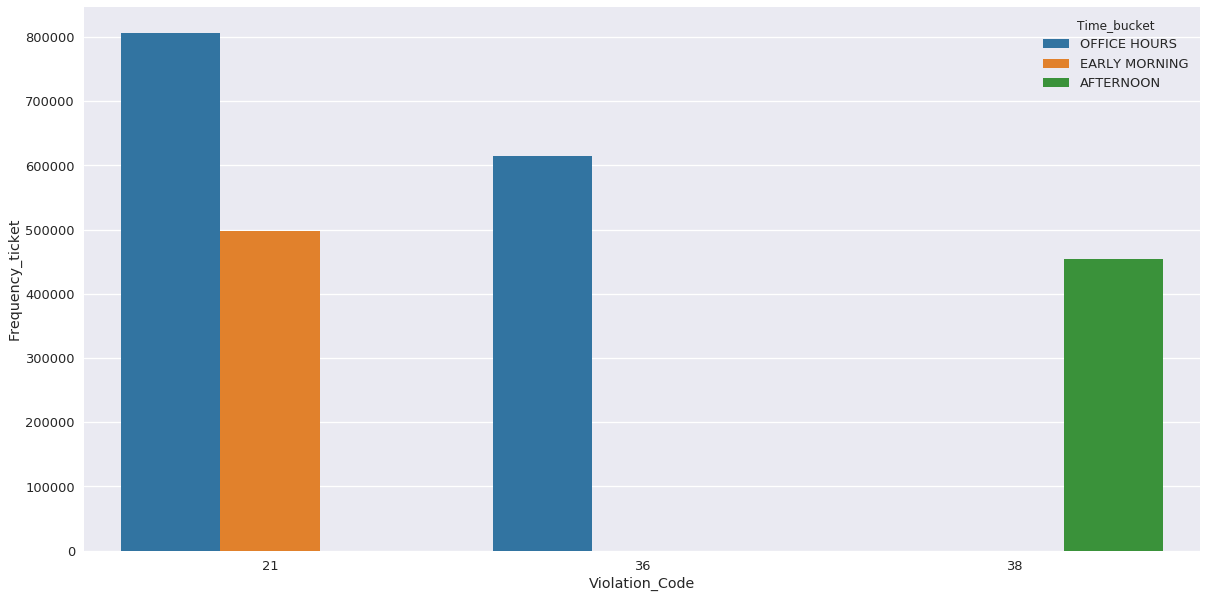

In [134]:
## ********* Plot the three most commonly occurring violation codes, find the most common time of the day *************
plt.figure(figsize=(20,10))
sns.set_context("talk")
sns.set_style("darkgrid")
sns.barplot(x="Violation_Code",y="Frequency_ticket",hue='Time_bucket',data=df_pandas.head(4))
## ********* Plot the three most commonly occurring violation codes, find the most common time of the day *************

<b>Comments:</b><br>
<ul>
    <li><mark> Most of the Violations are (First 3 - parts of the day)</mark> <br>
        <ul><li>Office Hours</li><li>Early Morning</li><li>Afternoon</li></ul>
    <li> <mark>Most of the Violations are (First 3 - Violation codes)</mark> <br>
        <ul><li>21</li><li>36</li><li>38</li></ul>
</ul>

<center> <b> ++++++++++ Answer 5 | End ++++++++++</b>  </center>

<center> <b> ++++++++++ Answer 6 | Start ++++++++++</b>  </center>

<b> Question 6: Let’s try and find some seasonality in this data:
</b>

<ul>
        <li>First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season. (Hint: Use Issue Date to segregate into seasons.)</li>
    <li>Then, find the three most common violations for each of these seasons.</li>
</ul>
<br>

In [135]:
## ******** Check the issue date *************
nyc_taxi_updated.select('Issue_Date').show()
## ******** Check the issue date *************

+-------------------+
|         Issue_Date|
+-------------------+
|2016-07-10 00:00:00|
|2016-07-08 00:00:00|
|2016-08-23 00:00:00|
|2017-06-14 00:00:00|
|2016-11-21 00:00:00|
|2017-06-13 00:00:00|
|2016-08-03 00:00:00|
|2016-12-21 00:00:00|
|2016-11-21 00:00:00|
|2016-10-05 00:00:00|
|2017-01-11 00:00:00|
|2016-09-27 00:00:00|
|2016-10-27 00:00:00|
|2016-09-30 00:00:00|
|2017-02-04 00:00:00|
|2016-07-07 00:00:00|
|2016-09-24 00:00:00|
|2017-01-26 00:00:00|
|2017-04-30 00:00:00|
|2017-02-03 00:00:00|
+-------------------+
only showing top 20 rows



In [136]:
## ********** Frequencies of tickets for each season ****************
spark.sql('''select CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons \
order by Cnt DESC''').show()
## ********** Frequencies of tickets for each season ****************

+-------+-------+
|Seasons|    Cnt|
+-------+-------+
| Winter|5320252|
| Summer|3018840|
|  Rainy|2463936|
+-------+-------+



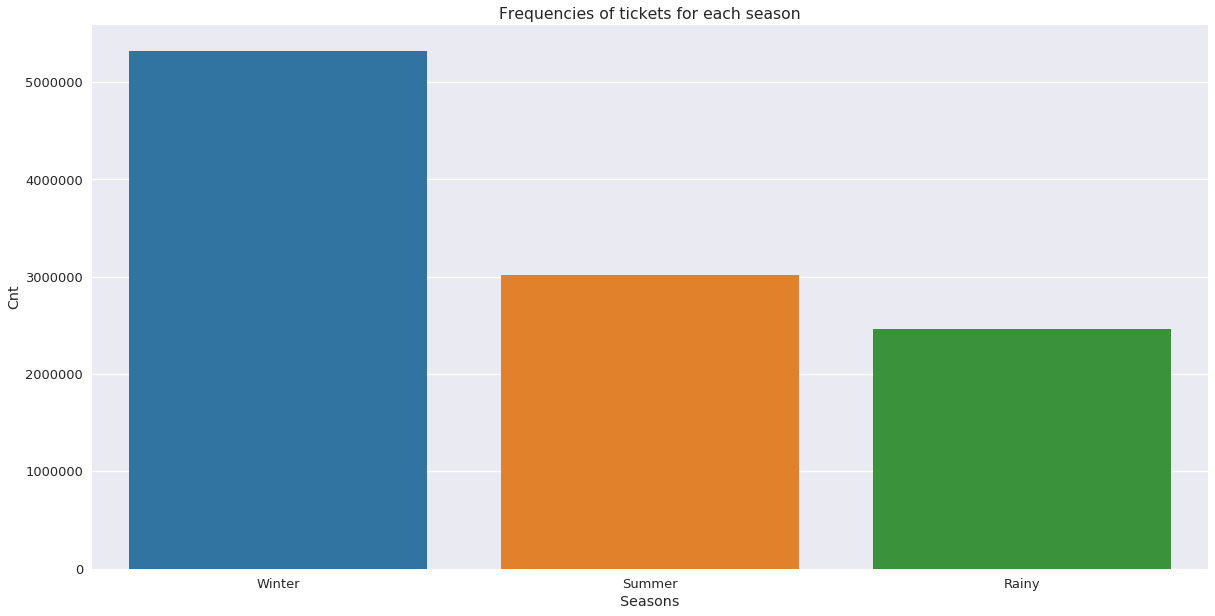

In [137]:
## ********* Frequencies of tickets for each season - Charts *************
freq_tckts=spark.sql('''select CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons \
order by Cnt DESC''')

df_pandas=freq_tckts.toPandas()

plt.figure(figsize=(20,10))
plt.title('Frequencies of tickets for each season')
sns.set_context("talk")
sns.set_style("darkgrid")
sns.barplot(x="Seasons",y="Cnt",data=df_pandas)
## ********* Frequencies of tickets for each season - Charts *************

<b> Comments: </b><br>
<mark>Winter tops the chart followed by Summer and Rainy being the least</mark>

In [138]:
## ********** Get the Count of violations by Seasons ****************
spark.sql('''select Violation_Code,CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons,Violation_Code \
order by Cnt DESC''').show(10)
## ********** Get the Count of violations by Seasons ****************

+--------------+-------+------+
|Violation_Code|Seasons|   Cnt|
+--------------+-------+------+
|            36| Winter|790833|
|            21| Winter|721630|
|            38| Winter|550410|
|            14| Winter|427780|
|            21| Summer|421184|
|            21|  Rainy|385774|
|            36| Summer|369902|
|            37| Winter|299506|
|            20| Winter|295969|
|            46| Winter|290224|
+--------------+-------+------+
only showing top 10 rows



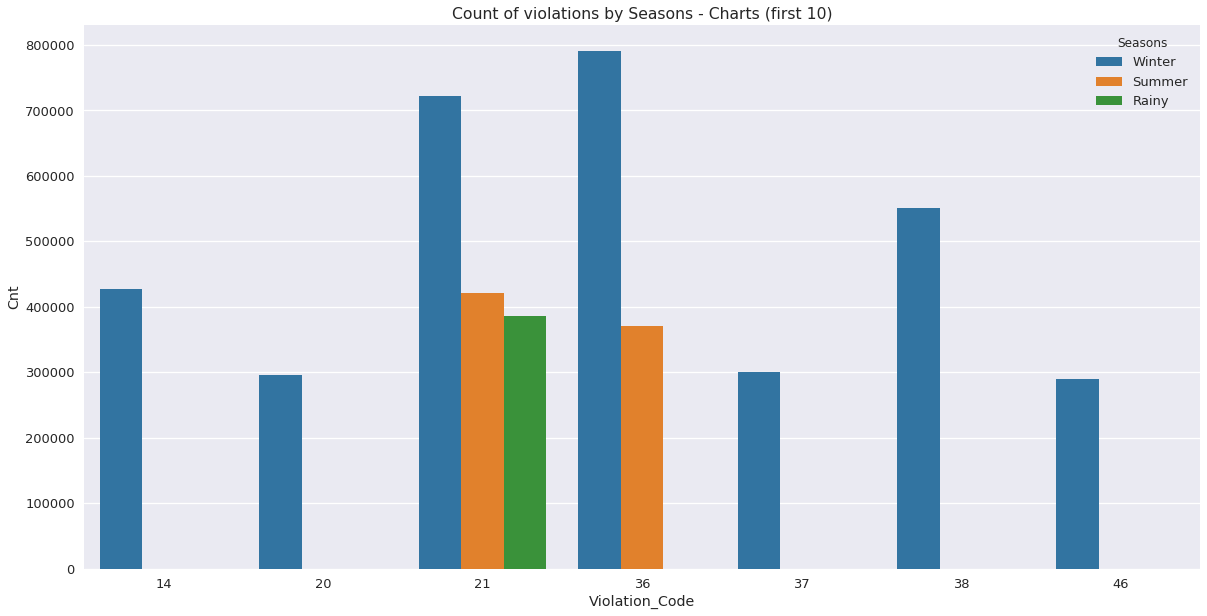

In [139]:
## ********* Get the Count of violations by Seasons - Charts (first 10) *************
freq_tckts=spark.sql('''select Violation_Code,CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons,Violation_Code \
order by Cnt DESC''')

df_pandas=freq_tckts.toPandas()

plt.figure(figsize=(20,10))
plt.title('Count of violations by Seasons - Charts (first 10)')
sns.set_context("talk")
sns.set_style("darkgrid")
sns.barplot(x="Violation_Code",y="Cnt",hue='Seasons',data=df_pandas.head(10))
## ********* Get the Count of violations by Seasons - Charts (first 10)  *************

<b> Comments: </b><br>
<ul>
    <li> Viloation Code - 36 tops the chart in Winter season </li>
    <li> Viloation Code - 21 comes next with violations in all the seasons </li>
</ul>

In [140]:
## ********** Get the Count of violations by Winter ****************
spark.sql('''select * from (select Violation_Code,CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons,Violation_Code \
order by Cnt DESC) as temp \
where Seasons ='Winter' ''').show(3)
## ********** Get the Count of violations by Winter ****************

+--------------+-------+------+
|Violation_Code|Seasons|   Cnt|
+--------------+-------+------+
|            36| Winter|790833|
|            21| Winter|721630|
|            38| Winter|550410|
+--------------+-------+------+
only showing top 3 rows



In [141]:
## ********** Get the Count of violations by Summer ****************
spark.sql('''select * from (select Violation_Code,CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons,Violation_Code \
order by Cnt DESC) as temp \
where Seasons ='Summer' ''').show(3)
## ********** Get the Count of violations by Summer ****************

+--------------+-------+------+
|Violation_Code|Seasons|   Cnt|
+--------------+-------+------+
|            21| Summer|421184|
|            36| Summer|369902|
|            38| Summer|266909|
+--------------+-------+------+
only showing top 3 rows



In [142]:
## ********** Get the Count of violations by Rainy ****************
spark.sql('''select * from (select Violation_Code,CASE \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 4  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=6 THEN 'Summer' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 7  and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=9 THEN 'Rainy' \
WHEN CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) >= 10 and CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=12 or (CAST(SUBSTRING(SUBSTRING_INDEX(Issue_Date,' ',1),6,2) AS INT) <=3) THEN 'Winter' \
ELSE 'NA'
END as Seasons, count(*) as Cnt from dfTable \
group by Seasons,Violation_Code \
order by Cnt DESC) as temp \
where Seasons ='Rainy' ''').show(3)
## ********** Get the Count of violations by Rainy ****************

+--------------+-------+------+
|Violation_Code|Seasons|   Cnt|
+--------------+-------+------+
|            21|  Rainy|385774|
|            38|  Rainy|244985|
|            36|  Rainy|239879|
+--------------+-------+------+
only showing top 3 rows



<b> Comments: </b><br>
<ul>
    <li> 
        <b>Winter (most 3 violations)</b> <br>
        <ul><li>36</li><li>21</li><li>38</li></ul>
    </li>
    <li> 
        <b>Summer (most 3 violations)</b> <br>
        <ul><li>21</li><li>36</li><li>38</li></ul>
    </li>
    <li> 
        <b>Rainy (most 3 violations)</b> <br>
        <ul><li>21</li><li>38</li><li>36</li></ul>
    </li>
</ul>
<br> It is quite evident that the three violations codes are common accross the seasons, <b><mark>21,36 & 38</mark></b>

<center> <b> ++++++++++ Answer 6 | End ++++++++++</b>  </center>

<center> <b> ++++++++++ Answer 7 | Start ++++++++++</b>  </center>

<b> Question: The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:</b><br>
<ul>
    <li>Find the total occurrences of the three most common violation codes.
        <li>Then, visit the website:
http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.
            <li>
Using this information, find the total amount collected for the three violation codes with the maximum tickets. State the code that has the highest total collection.<li>
What can you intuitively infer from these findings?

In [143]:
top_violation = spark.sql('select Violation_Code, count(*) as Frequency_of_Tickets from dfTable group by Violation_Code order by Frequency_of_Tickets desc')
top_violation.show(3)

+--------------+--------------------+
|Violation_Code|Frequency_of_Tickets|
+--------------+--------------------+
|            21|             1528588|
|            36|             1400614|
|            38|             1062304|
+--------------+--------------------+
only showing top 3 rows



In [144]:
from pyspark.sql.functions import sum
top_violation.where('Violation_Code in (21,36,38)').select(sum('Frequency_of_Tickets').alias("Total occurrences of 3 most common codes")).show()

+----------------------------------------+
|Total occurrences of 3 most common codes|
+----------------------------------------+
|                                 3991506|
+----------------------------------------+



In [145]:
#Based on the above results:
#The top three most common violation codes are 21,36 and 38
#Total 3991506 tickets has been issued for the top 3 violation codes.

Now, we visit the website:
http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, we take the average of the two.

In [146]:
collection=spark.sql("select Violation_Code, count(*) as freq_tickets,\
          CASE WHEN Violation_Code like 21 THEN CAST((65+45)/2 as INTEGER)\
          WHEN Violation_Code like 36 THEN CAST((50+50)/2 as INTEGER)\
          WHEN Violation_Code like 38 THEN CAST((65+35)/2 as INTEGER)\
          END AS FINE\
        from dfTable where Violation_Code IN (21,36,38) \
        group by Violation_Code order by freq_tickets desc")

In [147]:
collection.show()

+--------------+------------+----+
|Violation_Code|freq_tickets|FINE|
+--------------+------------+----+
|            21|     1528588|  55|
|            36|     1400614|  50|
|            38|     1062304|  50|
+--------------+------------+----+



In [148]:
collection.createOrReplaceTempView("dfTable")

In [149]:
# Find the total amount collected for the three violation codes with the maximum tickets
spark.sql("select Violation_Code,freq_tickets,FINE,freq_tickets*FINE as total_collection from dfTable").show()

+--------------+------------+----+----------------+
|Violation_Code|freq_tickets|FINE|total_collection|
+--------------+------------+----+----------------+
|            21|     1528588|  55|        84072340|
|            36|     1400614|  50|        70030700|
|            38|     1062304|  50|        53115200|
+--------------+------------+----+----------------+



Based on the above results:
The total amount collected for the three violation codes with the maximum tickets is as below:
<ul>
    <li>
        21 - 84072340
        <li>
            36 - 70030700
            <li>
                38 - 53115200
                


Hence, Code that has the highest total collection is <b>21

<B>Inference from these findings-

From these findings, we can infer the below - 
<li> The most violations are due to are violation code 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
<li> This is followed by violation code 36 - Exceeding the posted speed limit in or near a designated school zone.
<li> Violation code 38 is followed next - Failing to show a receipt or tag in the windshield.
Drivers get a 5-minute grace period past the expired time on parking meter receipts.
<li> Total amount collected from the violation codes with max tickets is ~207M

<center> <b> ++++++++++ Answer 7 | End ++++++++++</b>  </center>

In [150]:
spark.stop() #We should always stop Spark whenever we finish working on the cluster.